In [ ]:
# https://www.youtube.com/watch?v=rckCSs0GiKA&t=31s
# https://www.youtube.com/watch?v=edUHhKFfJOg&t=2072s

# https://www.youtube.com/watch?v=GIvz7qCvIFU
# https://www.youtube.com/watch?v=Kzoc5PdJ-Wo
# https://www.youtube.com/watch?v=gnCktevu_wk

# slide
# https://fr.slideshare.net/slideshow/ng-dng-nlp-vo-vic-xc-nh-mun-ngi-dng-intent-detection-v-sa-li-chnh-t-trong-ting-vit-spell-correction/116386074
# https://www.studocu.com/vn/document/truong-dai-hoc-ngoai-thuong/tieng-anh-thuong-mai/123doc-bat-loi-chinh-ta-bang-phuong-phap-transformer/38879406
# https://github.com/vovanphuc/VIETNAMESE_NLP/blob/master/functions/spell_correction.py

# https://github.com/huynhnhathao/vietnamese_spelling_error_correction
# https://www.youtube.com/watch?v=GIvz7qCvIFU&t=511s
# https://github.com/VietHoang1512/Vietnamese-Spell-Correction/blob/master/transfer_spell.ipynb
# https://github.com/VietHoang1512/vietnamese-spell-correct-and-text-classify/blob/master/add_noise.py

In [ ]:
# !rm -rf /content/drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Install Package**

In [ ]:
! pip install crochet
! pip install sentencepiece
! pip install unidecode
! pip install scrapy
! pip install transformers
! pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=8701eb1d8c7f094819b88799c697e52968939cb80587c3a544ee6f96985f1ede
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **Import Libraries**

In [ ]:
import scrapy
from scrapy.crawler import CrawlerProcess
from crochet import setup
import scrapy.crawler as crawler
from multiprocessing import Process, Queue
from twisted.internet import reactor
import numpy as np
from urllib.request import urlopen
import re
from bs4 import BeautifulSoup

In [ ]:
import sentencepiece as spm
import os
import numpy as np
import re
import time
from tqdm.notebook import tqdm
import pandas as pd
from nltk.tokenize import word_tokenize
import unidecode
import string
from tqdm.notebook import tqdm
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [ ]:
import json
import logging
import seaborn as sns
import copy
import gc
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from transformers import AdamW, get_linear_schedule_with_warmup
from easydict import EasyDict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from seqeval.metrics import precision_score as seq_precision, recall_score as seq_recall, f1_score as seq_f1
from transformers import AutoTokenizer, XLMRobertaModel, XLMRobertaForMaskedLM
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# **Create Raw Document**


## **Get Document Từ VnExpress**

In [ ]:
def get_links(url, domain_url):
    links = []
    html = urlopen(url, timeout=14).read()
    soup = BeautifulSoup(html, 'html.parser')
    # Lấy tất cả URL trong trang web
    urls = set(re.findall(r'(?:http|https|ftp):\/\/(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])', str(soup)))

    for url in urls:
        # Chỉ lấy đường dẫn là trang web chứa bài báo
        if url != domain_url and url.startswith(domain_url) and not url.startswith(domain_url + '/tac-gia') and url.endswith('.html'):
            links.append(url)
    return links

def get_category_urls(categories, domain_url, page_limit):
    cate_url = {}
    for cate in categories:
        cate_url[cate] = []

        # Lọc qua từng trang
        for i in range(1, page_limit + 1):
            url = '{}/{}-p{}'.format(domain_url, cate, str(i))
            cate_url[cate] += get_links(url, domain_url)

        # Loại bỏ URL trùng lặp
        cate_url[cate] = list(set(cate_url[cate]))

        # In số đường dẫn thu được trong từng mục
        print(f"{cate}: {len(cate_url[cate])} links")
        print(cate_url[cate])
        # for link in cate_url[cate][:3]:
        #   print(link)

    return cate_url

In [ ]:
def run_spider(spider_cls, category, start_urls):
    def f(q):
        try:
            runner = crawler.CrawlerRunner()
            deferred = runner.crawl(spider_cls, category=category, start_urls=start_urls)
            deferred.addBoth(lambda _: reactor.stop())
            reactor.run()
            q.put(None)
        except Exception as e:
            q.put(e)

    q = Queue()
    p = Process(target=f, args=(q,))
    p.start()
    result = q.get()
    p.join()

    if result is not None:
        raise result

In [ ]:
CATEGORIES = ['thoi-su', 'the-gioi', 'kinh-doanh', 'y-kien', 'the-thao', 'phap-luat', 'thu-gian', 'giao-duc', 'suc-khoe', 'so-hoa', 'doi-song', 'du-lich']
DOMAIN_URL = 'https://vnexpress.net'
DOMAIN_URL1 = 'https://thanhnien.vn/'
PAGE_LIMIT = 10
LINK_DRIVE = '/content/drive/MyDrive/NLP_Projects'

In [ ]:
class VNExpressSpider(scrapy.Spider):
    name = 'vnexpress_crawler'
    allowed_domains = ['vnexpress.net']

    def __init__(self, category, start_urls, *args, **kwargs):
        super(VNExpressSpider, self).__init__(*args, **kwargs)
        self.category = category
        self.start_urls = start_urls

    def parse(self, response):
        # Theo dõi các liên kết tiếp theo
        for next_page in response.css("li > a::attr(href)").re(r'https.*'):
            yield response.follow(next_page, self.parse)

        # Thu thập và ghi nội dung
        for para in [response.css('section').css('h1::text').get() + ' '] + response.css('section').css('p::text').getall():
            with open(f'{LINK_DRIVE}/Raw Text/rawtext_{self.category}.txt', 'a', encoding='utf-8') as f:
                f.write(para)

In [ ]:
# Lấy URL cho từng mục
os.makedirs(f'{LINK_DRIVE}/Raw Text', exist_ok=True)
category_urls = get_category_urls(CATEGORIES, DOMAIN_URL, PAGE_LIMIT)

thoi-su: 317 links
['https://vnexpress.net/phu-quoc-tam-dung-cho-can-bo-di-nuoc-ngoai-4749585.html', 'https://vnexpress.net/thu-tuong-pham-minh-chinh-thuc-hien-nghi-thuc-tam-phat-4749094.html', 'https://vnexpress.net/bo-truong-dang-quoc-khanh-lan-dau-tra-loi-chat-van-4753913.html', 'https://vnexpress.net/chuyen-gia-lam-dao-vuon-tren-song-la-giai-phap-kien-truc-moi-4750086.html', 'https://vnexpress.net/hang-loat-cay-xanh-o-tp-hcm-chet-bat-thuong-4755083.html', 'https://vnexpress.net/thu-tuong-de-nghi-tap-doan-fedex-express-tang-chuyen-bay-o-viet-nam-4755328.html', 'https://vnexpress.net/bo-truong-nguyen-van-hung-gia-ve-may-bay-da-ha-nhiet-4754902-tong-thuat.html', 'https://vnexpress.net/hon-100-ho-so-den-bu-cao-toc-o-dong-nai-co-dau-hieu-chinh-sua-4751490.html', 'https://vnexpress.net/4-oto-tong-lien-hoan-tren-quoc-lo-1-4752706.html', 'https://vnexpress.net/nat-no-benh-nhan-y-si-bi-dieu-chuyen-cong-tac-4753917.html', 'https://vnexpress.net/tai-de-xuat-csgt-duoc-trich-mot-phan-tien-phat-

In [ ]:
# Chạy Spider cho từng mục
for category, urls in category_urls.items():
    run_spider(VNExpressSpider, category, urls)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
ERROR:scrapy.core.scraper:Spider error processing <GET https://vm.vnexpress.net/hai-phong-2023/tin-tuc> (referer: https://vm.vnexpress.net)
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/scrapy/utils/defer.py", line 279, in iter_errback
    yield next(it)
  File "/usr/local/lib/python3.10/dist-packages/scrapy/utils/python.py", line 350, in __next__
    return next(self.data)
  File "/usr/local/lib/python3.10/dist-packages/scrapy/utils/python.py", line 350, in __next__
    return next(self.data)
  File "/usr/local/lib/python3.10/dist-packages/scrapy/core/spidermw.py", line 106, in process_sync
    for r in iterable:
  File "/usr/local/lib/python3.10/dist-packages/scrapy/spidermiddlewares/referer.py", line 352, in <genexpr>
    return (self._set_referer(r, response) for r in result or ())
  File "/usr/local/lib/python3.10/dist-packages/scrapy/core/spidermw.py", line 106, in process_sync
    for r

KeyboardInterrupt: 

## **Visualize**

In [ ]:
def visualize_data(categories):
  for category in categories:
    input_file = f'{LINK_DRIVE}/Raw Text/rawtext_{category}.txt'
    all_sentences = []
    # Đọc dữ liệu từ tệp input
    try:
      with open(input_file, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    except FileNotFoundError:
      return 0

    # Tách câu dựa trên các dấu câu
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)(?=\s|[A-Z])', raw_text)
    special_chars = r'[-.(),\/?~!:^%$#@\]'
    sentences = [re.sub(r'\d+', '', sentence) for sentence in sentences]
    sentences = [re.sub('[{}]'.format(re.escape(special_chars)), '', sentence) for sentence in sentences]
    sentences = [re.sub(r'\s+', ' ', sentence).strip() for sentence in sentences]

    all_sentences.extend(sentences)
    num_sentences = len(sentences)

    seq_len = [len(i.strip().split()) for i in all_sentences[:num_sentences]]
    pd.Series(seq_len).hist(bins=30)
    plt.show()

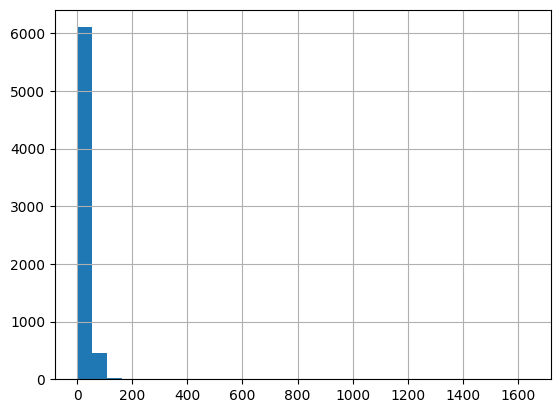

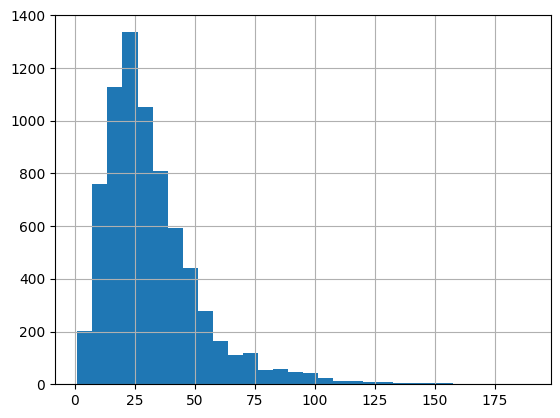

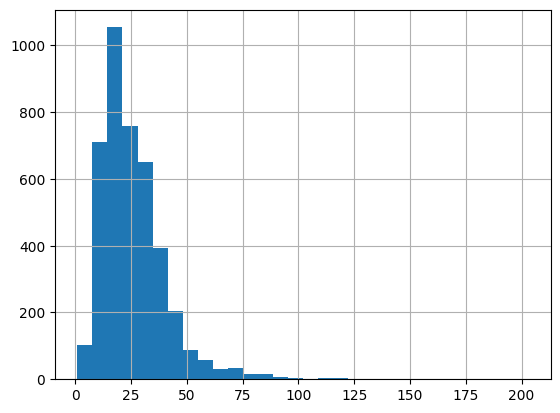

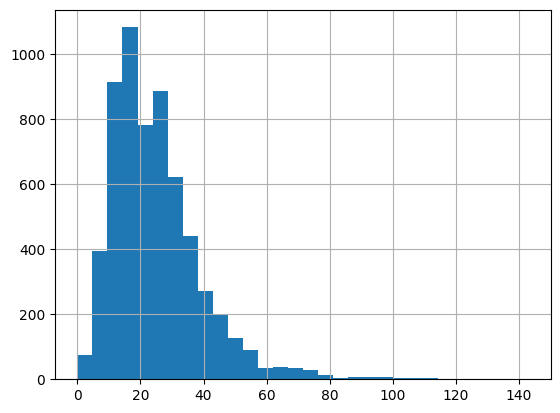

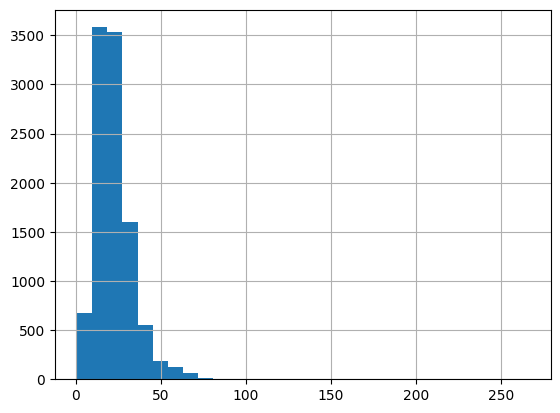

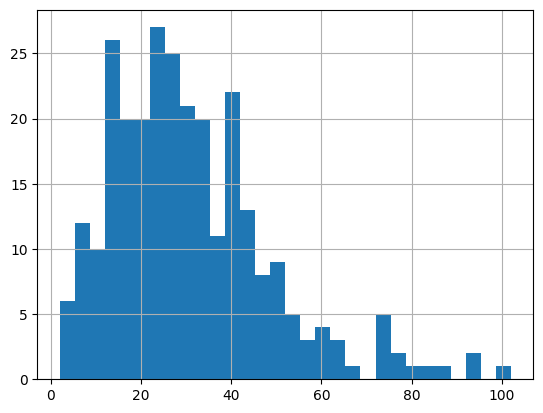

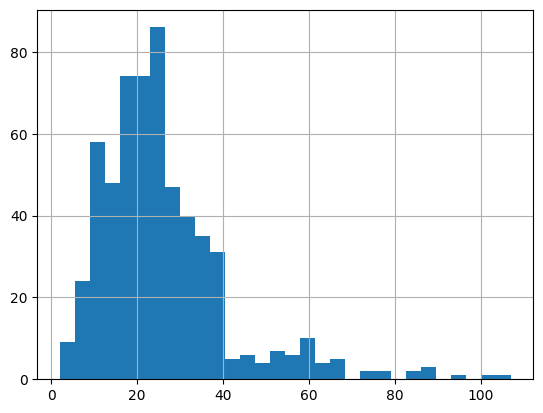

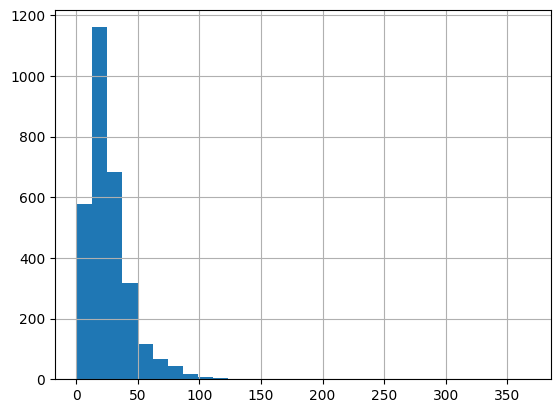

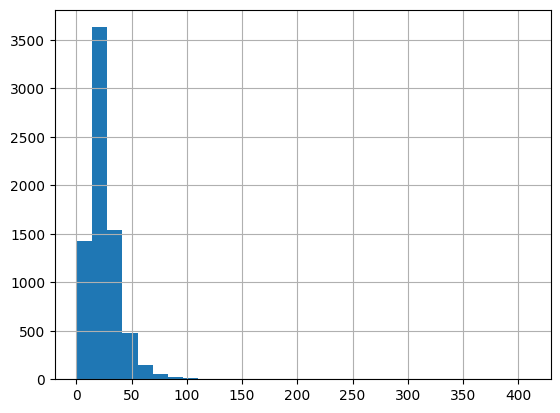

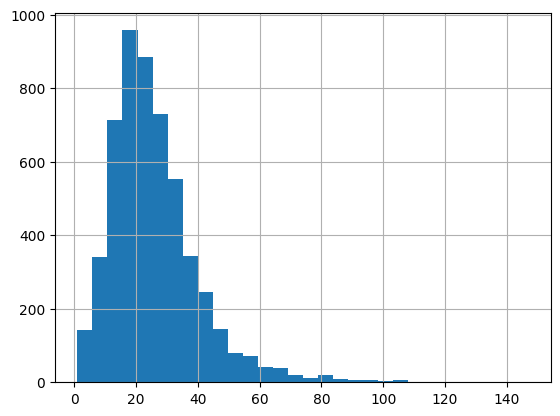

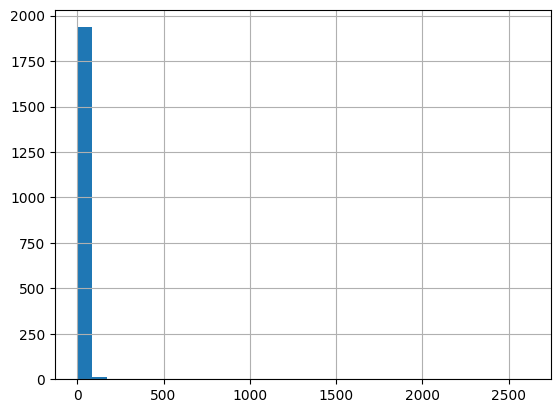

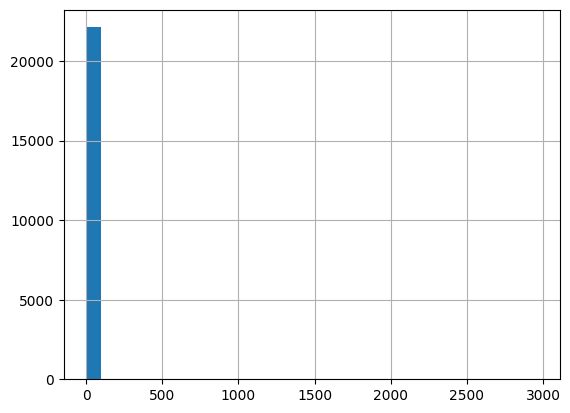

In [ ]:
visualize_data(CATEGORIES)

## **Create Corpus File**

In [ ]:
all_sentences = []

def process_file(input_file, output_file, min_seq_len, max_seq_len):
    # Đọc dữ liệu từ tệp input
    try:
      with open(input_file, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    except FileNotFoundError:
      return 0

    # xử lý dữ liệu
    special_chars = r'[-(),\/?~!^%$#@\]'
    raw_text = re.sub(r'\d+', '', raw_text)
    raw_text = re.sub('[{}]'.format(re.escape(special_chars)), '', raw_text)
    raw_text = re.sub('[{}]'.format(re.escape('.')), ' ', raw_text)
    raw_text = re.sub(r'\s+', ' ', raw_text).strip()
    raw_text = raw_text.lower()

    # split câu [min:max]
    lines = []
    raw_text = raw_text.split()
    raw_text_len = len(raw_text)
    while True:
      line_len = np.random.randint(min_seq_len, max_seq_len)
      if raw_text_len < line_len :
        break
      line = ' '.join(raw_text[:line_len])
      raw_text = raw_text[line_len:]
      lines.append(line)
      raw_text_len -= line_len

    num_sentences = len(lines)
    for i in lines:
      all_sentences.append(i.strip())

    return num_sentences

def create_corpus(categories):
    for category in categories:
        input_file = f'{LINK_DRIVE}/Raw Text/rawtext_{category}.txt'
        output_file = f'{LINK_DRIVE}/Raw Lines Text/rawtext_lines_{category}.txt'

        #  số câu tách được
        num_sentences = process_file(input_file, output_file, MIN_SEQ_LEN, MAX_SEQ_LEN)
        print(f'{category}: {num_sentences}')

    # Write all sentences to corpus.txt
    print("Tổng số câu trong Corpus: ", len(all_sentences))
    with open(f'{LINK_DRIVE}/corpus.txt', 'w', encoding='utf-8') as f:
        for sentence in all_sentences:
            f.write(sentence.strip() + '\n')

In [ ]:
MIN_SEQ_LEN = 25
MAX_SEQ_LEN = 50
create_corpus(CATEGORIES)

thoi-su: 5353
the-gioi: 6306
kinh-doanh: 2911
y-kien: 4161
the-thao: 6319
phap-luat: 232
thu-gian: 408
giao-duc: 2177
suc-khoe: 5084
so-hoa: 3809
doi-song: 1535
du-lich: 14523
Tổng số câu trong Corpus:  52818


# **Create Data**

## **Build The Sentence Piece Tokenizer**

In [ ]:
input_corpus_file = f'{LINK_DRIVE}/corpus.txt'
model_output_path = f'{LINK_DRIVE}/tokenizer'
VOCAB_SIZE = 15024

In [ ]:
spm.SentencePieceTrainer.train(f'--input={input_corpus_file} --model_prefix={model_output_path} --vocab_size={VOCAB_SIZE}')

In [ ]:
# link tokenize and vocab file
model_file = f'{LINK_DRIVE}/tokenizer.model'
vocab_file = f'{LINK_DRIVE}/tokenizer.vocab'

# Load mô hình tokenizer
sp = spm.SentencePieceProcessor()
sp.load(model_file)

# Print thông tin tập vocab
print("Số lượng token trong mô hình:", sp.get_piece_size())
with open(vocab_file, encoding="utf-8") as f:
    vocab = f.readlines()
print("Vocabulary:")
for line in vocab[:20]:
    print(line.strip())

Số lượng token trong mô hình: 15024
Vocabulary:
<unk>	0
<s>	0
</s>	0
▁và	-4.39167
▁có	-4.58477
▁của	-4.68916
▁là	-4.71418
▁trong	-4.81987
▁các	-4.88326
▁một	-4.95296
▁không	-4.96918
▁được	-4.97641
▁cho	-4.9809
▁	-4.99499
▁người	-5.00689
▁với	-5.03179
▁ở	-5.10868
▁khi	-5.24964
▁những	-5.29416
▁để	-5.3017


## **Create list wrong spelling**

In [ ]:
# Bảng chữ cái Tiếng Việt
vocab_size = VOCAB_SIZE
vn_alphabet = ['a',  'ă', 'â', 'b' ,'c', 'd', 'đ', 'e', 'ê', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'ô', 'ơ', 'p', 'q', 'r', 's', 't', 'u', 'ư', 'v', 'x', 'y']


# Chữ cái đồng âm
char_couples = [['i', 'y'], ['s', 'x'], ['gi', 'd'], ['ă', 'â'], ['ch', 'tr'], ['ng', 'n'], ['nh', 'n'], ['ngh', 'ng'], ['ục', 'uộc'], ['o', 'u'], ['qu', 'q'], ['i','j'],
                ['ă', 'a'], ['o', 'ô'], ['ả', 'ã'], ['ổ', 'ỗ'], ['ủ', 'ũ'], ['ễ', 'ể'], ['ấ', 'á'],['n', 'l'], ['qu', 'w'], ['ph', 'f'], ['d', 'z'], ['c', 'k'], ['gi', 'j'],
                ['e', 'ê'], ['à', 'ờ'], ['ằ', 'à'], ['ẩn', 'uẩn'],  ['ẽ', 'ẻ'], ['ùi', 'uồi'], ['ă', 'â'], ['ở', 'ỡ'], ['ỹ', 'ỷ'], ['ỉ', 'ĩ'], ['ị', 'ỵ']]

# Từ đồng âm, đồng từ
word_couples = [['kì', 'kỳ'], ['sương', 'xương'], ['sĩ', 'sỹ'], ['sẽ', 'sẻ'], ['sã', 'sả'], ['sả', 'xả'], ['sẽ', 'sẻ'], ['mùi', 'muồi'], ['mát', 'mác'], ['chích', 'chít'],
                ['kiêm', 'kim'], ['chỉnh', 'chỉn'], ['sữa', 'sửa'], ['chuẩn', 'chẩn'], ['lẻ', 'lẽ'], ['chẳng', 'chẵng'], ['cổ', 'cỗ'], ['uy', 'quy'], ['xinh', 'sinh'],
                ['bài', 'bày'], ['sát', 'xát'], ['cập', 'cặp'], ['truyện', 'chuyện'], ['xá', 'sá'], ['giả', 'dả'], ['đỡ', 'đở'], ['chắc', 'chắt'], ['nghĩ', 'nghỉ'],
                ['giữ', 'dữ'], ['giã', 'dã'], ['xảo', 'sảo'], ['kiểm', 'kiễm'], ['cuộc', 'cục'], ['dạng', 'dạn'], ['tuyệt', 'tiệc'], ['miết', 'mít'], ['tích', 'tít'],
                ['tản', 'tảng'], ['ngành', 'nghành'], ['nghề', 'ngề'], ['nổ', 'nỗ'], ['rảnh', 'rãnh'], ['sẵn', 'sẳn'], ['vẻ', 'vẽ'], ['gian', 'giang'], ['triệu', 'chiệu'],
                ['sáng', 'xán'], ['xuất', 'suất'], ['suôn', 'suông'], ['sử', 'xử'], ['sắc', 'xắc'], ['chữa', 'chửa'], ['chất', 'chấc'], ['báo', 'báu'], ['cháo', 'cháu'],
                ['thắn', 'thắng'], ['dỡ', 'dở'], ['trải', 'trãi'], ['trao', 'trau'], ['trung', 'chung'], ['thăm', 'tham'], ['câm', 'căm'], ['củ', 'cũ'], ['sửa', 'xửa'],
                ['sét', 'xét'], ['dục', 'giục'], ['tả', 'tã'],['sông', 'xông'], ['sáo', 'xáo'], ['sang', 'xang'], ['sửu', 'xửu'], ['gian', 'giang'], ['kỹ', 'kĩ'],
                ['ngã', 'ngả'], ['xuống', 'suống'], ['xuồng', 'suồng'], ['trúc', 'trút'], ['bọc', 'lọc'], ['ước', 'ướt'], ['bắt', 'bắc'], ['máy', 'mái'], ['nghiêng', 'nghiên']]

# Từ viết tắt (teencode)
teencode = {'mình': ['mk', 'mik', 'mjk'], 'vô': ['dô','zô', 'zo', 'vo'], 'vậy':['zậy', 'z', 'zay', 'za', 'dị'] , 'phải': ['fải', 'fai'], 'biết': ['bit', 'biet', 'bít'],
            'gì': ['j', 'gi'], 'rồi':['rùi', 'ròi', 'r'], 'bây': ['bi', 'bay'], 'giờ': ['h', 'bh'], 'không': ['k', 'ko', 'khong', 'hk', 'hong', 'hông', '0', 'kg', 'kh', 'khum'],
            'học': ['hc'], 'đi': ['di', 'dj', 'ik'], 'gì': ['j'], 'em': ['e'], 'anh': ['a'], 'được': ['dc', 'đc'], 'tôi': ['t', 'tui'], 'chồng': ['ck'], 'vợ':['vk'],
            'chị': ['c'],  'yêu': ['iu', 'êu', 'love'],  'thích': ['thick', 'like'],  'nhiều': ['nhìu'],  'hả': ['hửm', 'hỏ', 'ỏ'],  'rồi': ['rùi', 'ròi', 'gòi'],
            'hôn': ['hun', 'moa'],  'mà': ['mừ'],  'ừa': ['ùa', 'ừmm', 'ừm', 'umm'],  'có': ['cóa'], 'thôi': ['thui', 'thoi'], 'muốn': ['mún'], 'trời': ['chời'],
            'tao': ['t'], 'mày': ['m', 'mầy', 'mâi'],  'xíu': ['xí'],  'cười': ['cừ', 'cừi'], 'chung': ['chug'], 'lớp': ['lp', 'l4p'], 'với': ['vs'], 'bạn': ['bợn', 'bff'],
            'trước': ['tr'], 'người': ['ng', 'ngừ', 'ngừi'], 'nghìn': ['k'], 'làm': ['lm'], 'chưa': ['ch'], 'ê': ['ey', 'ee', 'ei'], 'luôn': ['lun'], 'tiếp': ['típ']}

# Lỗi đánh máy
telex = { "aw": "ă", "aa": "â", "as": "á", "af": "à", "ar": "ả", "ax": "ã", "aj": "ạ", "aws": "ắ", "awf": "ằ", "awr": "ẳ", "awx": "ẵ", "awj": "ặ", "aaj": "ậ", "aas": "ấ", "aaf": "ầ", "aar": "ẩ", "aax": "ẫ",
          "oo": "ô", "oos": "ố", "oof": "ồ", "oor": "ổ", "oox": "ỗ", "ooj": "ộ", "ow": "ơ", "ows": "ớ", "owf": "ờ", "owr": "ở", "owx": "ỡ", "owj": "ợ",
          "os": "ó", "of": "ò", "or": "ỏ", "ox": "õ", "oj": "ọ", "ee": "ê", "ees": "ế", "eef": "ề", "eer": "ể", "eex": "ễ", "eej": "ệ",
          "es": "é", "ef": "è", "er": "ẻ", "ex": "ẽ", "ej": "ẹ", "us": "ú", "uf": "ù", "ur": "ủ", "ux": "ũ", "uj": "ụ",
          "uw": "ư", "uws": "ứ", "uwf": "ừ", "uwr": "ử", "uwx": "ữ", "uwj": "ự","is": "í", "if": "ì", "ir": "ỉ", "ix": "ĩ", "ij": "ị",
          "ys": "ý", "yf": "ỳ", "yr": "ỷ", "yx": "ỹ", "yj": "ỵ", "dd": "đ"}

vni = { "a8": "ă", "a6": "â", "a1": "á", "a2": "à", "a3": "ả", "a4": "ã", "a5": "ạ", "a81": "ắ", "a82": "ằ", "a83": "ẳ", "a84": "ẵ", "a85": "ặ",
        "a61": "ấ", "a62": "ầ", "a63": "ẩ", "a64": "ẫ", "a65": "ậ", "e1": "é", "e2": "è", "e3": "ẻ", "e4": "ẽ", "e5": "ẹ", "e6": "ê",
        "e61": "ế", "e62": "ề", "e63": "ể", "e64": "ễ", "e65": "ệ", "i1": "í", "i2": "ì", "i3": "ỉ", "i4": "ĩ", "i5": "ị",
        "o1": "ó", "o2": "ò", "o3": "ỏ", "o4": "õ", "o5": "ọ", "o6": "ô", "o61": "ố", "o62": "ồ", "o63": "ổ", "o64": "ỗ", "o65": "ộ",
        "o7": "ơ", "o71": "ớ", "o72": "ờ", "o73": "ở", "o74": "ỡ", "o75": "ợ", "u1": "ú", "u2": "ù", "u3": "ủ", "u4": "ũ", "u5": "ụ",
        "u7": "ư", "u71": "ứ", "u72": "ừ", "u73": "ử", "u74": "ữ", "u75": "ự", "y1": "ý", "y2": "ỳ", "y3": "ỷ", "y4": "ỹ", "y5": "ỵ", "d9": "đ"}


## **Build CreateWrongData class**

In [ ]:
class CreateWrongData:
    def __init__(self, vn_alphabet, char_couples, word_couples, teencode, telex, vni, vocab, vocab_size):
        self.loop_limit = 10
        self.vocab = vocab
        self.vocab_size = vocab_size
        self.tokenizer = word_tokenize
        self.vn_alphabet = vn_alphabet
        self.char_couples = char_couples
        self.word_couples = word_couples
        self.teencode = teencode
        self.telex = telex
        self.vni = vni
        self.all_char_candidates = self.get_all_char_candidates()
        self.all_word_candidates = self.get_all_word_candidates()

    # ====================================================================================#
    #                                 Replace Methods                                     #
    # ====================================================================================#
    def replace_teencode(self, word):
        """
        return Thay thế teencode của input
        idea   Tìm input word trong tập teencode -> Nếu có xét len(teencode) -> if (len > 1) -> random index / else teencode[0]
        """
        candidates = self.teencode.get(word, None)
        if candidates is not None:
            idx = 0
            if len(candidates) > 1:
                idx = np.random.randint(0, len(candidates))
            return candidates[idx]


    def replace_telex(self, word):
        """
        return Thay thế từ telex của input
        """
        replaced_text = word
        # Thay thế từng cặp ký tự Telex trong từ điển
        for telex, vietnamese in self.telex.items():
            replaced_text = replaced_text.replace(vietnamese, telex)
        return replaced_text


    def replace_vni(self, word):
        """
        return Thay thế từ vni của input
        """
        replaced_text = word
        # Thay thế từng cặp ký tự VNI trong từ điển
        for vni, vietnamese in self.vni.items():
            replaced_text = replaced_text.replace(vietnamese, vni)

        return replaced_text


    def replace_char_candidate(self, char):
        """
        return Thay thế kí tự đồng âm của input
        """
        for couple in self.char_couples:
            if char in couple:
                return couple[1] if couple[0] == char else couple[0]


    def replace_word_candidate(self, word):
        """
        return Thay thế từ đồng âm & từ teencode của input
        idea   Thay thế từ đồng âm: lấy từng list -> lọc qua 1 trong 2 từ thuộc list nếu input có trong list thì lấy idx của từ
                                    -> thay bằng từ còn lại (viết hoa chữ cái đầu mỗi từ nếu flag=True)
               Thay thế từ teencode: call hàm replace_teencode()
        """
        # kiểm tra kí tự đầu có viết hoa không
        capital_flag = word[0].isupper()
        word_lower  = word.lower()
        # thay thế từ teencode
        if word_lower in self.teencode:
            replacement = self.replace_teencode(word_lower)
            return replacement.capitalize() if capital_flag else replacement
        # thay thế từ đồng âm ['tản', 'tảng']
        for couple in self.word_couples:
            if word_lower in couple:
                index = couple.index(word_lower)
                replacement = couple[1 - index]
                return replacement.capitalize() if capital_flag else replacement
        return word


    def get_all_char_candidates(self):
        all_char_candidates = []
        for char in self.char_couples:
            all_char_candidates.extend(char)
        return all_char_candidates


    def get_all_word_candidates(self):
        all_word_candidates = []
        for word in self.word_couples:
            all_word_candidates.extend(word)
        return all_word_candidates


    # ===============================================================================================#
    #                        Chỉnh sửa lỗi Tiếng Việt (gồm 6 lỗi)                                    #
    #  1. Loại bỏ các dấu của từ                                                                     #
    #  2. Thay thế, thêm, xóa kí tự(subword/letter) ngẫu nhiên bằng kí tự ngẫu nhiên trong alphabet  #
    #  3. Thay thế từ(word) ngẫu nhiên bằng từ ngẫu nhiên trong tập vocab                            #
    #  4. Thay thế từ(word) đồng âm + từ teencode                                                    #
    #  5. Thay thế kí tự(subword/letter) đồng âm                                                     #
    #  6. Thay thế các từ lỗi đánh máy (telex + vni)                                                 #
    # ===============================================================================================#

    def remove_punctuation(self, text, onehot_label):
        """
        Loại bỏ các dấu của từ
        Args:
            text: list tokenize word
            onehot_label: array one-hot đánh dấu label cho vị trí đã replace (label==1 -> đã replace)
        return: boolean, text, onehot_label -> kết quả, list tokenize word, array one-hot đã remove dấu
        """
        idx = np.random.randint(0, len(onehot_label))
        prevent_loop = 0
        # nếu label=1 (đã sửa) -> random idx khác
        while onehot_label[idx] == 1 or text[idx] == unidecode.unidecode(text[idx]) or text[idx] in string.punctuation:
            idx = np.random.randint(0, len(onehot_label))
            prevent_loop += 1
            if prevent_loop > self.loop_limit:
                return False, text, onehot_label

        # nếu label=0 (chưa sửa) -> remove dấu
        onehot_label[idx] = 1 # đánh dấu đã update
        text[idx] = unidecode.unidecode(text[idx])
        return True, text, onehot_label


    def replace_with_random_letter(self, text, onehot_label):
        """
        Thay thế, thêm, xóa kí tự(subword/letter) ngẫu nhiên bằng kí tự ngãu nhiên trong alphabet
        replace(0) || add(1) || remove(2)
        """
        idx = np.random.randint(0, len(onehot_label))
        prevent_loop = 0
        while onehot_label[idx] == 1 or text[idx].isnumeric() or text[idx] in string.punctuation:
            idx = np.random.randint(0, len(onehot_label))
            prevent_loop += 1
            if prevent_loop > self.loop_limit:
                return False, text, onehot_label

        coin = np.random.choice([0, 1, 2])
        chosen_letter = text[idx][np.random.randint(0, len(text[idx]))] # chọn kí tự ngẫu nhiên
        try:
            if coin == 0:
                replaced = self.vn_alphabet[np.random.randint(0, self.alphabet_len)]
            elif coin == 1:
                replaced = chosen_letter + self.vn_alphabet[np.random.randint(0, self.alphabet_len)]
            else:
                replaced = ''
            text[idx] = re.sub(chosen_letter, replaced, text[idx])
        except:
            return False, text, onehot_label

        onehot_label[idx] = 1 # đánh dấu đã update
        return True, text, onehot_label


    def replace_with_random_word(self, text, onehot_label):
        """
        Thay thế từ(word) ngẫu nhiên bằng từ ngẫu nhiên trong tập vocab
        """
        idx = np.random.randint(0, len(text))
        prevent_loop  = 0
        while onehot_label[idx] == 1 or text[idx].isnumeric() or text[idx] in string.punctuation:
            idx = np.random.randint(0, len(text))
            prevent_loop += 1
            if prevent_loop > 10:
                return False, text, onehot_label

        chosen_idx = np.random.randint(0, self.vocab_size)
        text[idx] = self.vocab[chosen_idx][0].replace('▁', '')

        onehot_label[idx] = 1
        return True, text, onehot_label


    def replace_with_homophone_word(self, text, onehot_label):
        """
        Thay thế từ(word) đồng âm + từ teencode
        """
        candidates = []
        for i in range(len(text)):
            if text[i].lower() in self.all_word_candidates or text[i].lower() in self.teencode.keys():
                candidates.append((i, text[i]))

        if len(candidates) == 0:
            return False, text, onehot_label
        idx = np.random.randint(0, len(candidates))
        prevent_loop = 0
        while onehot_label[candidates[idx][0]] == 1:
            idx = np.random.randint(0, len(candidates))
            prevent_loop += 1
            if prevent_loop > self.loop_limit:
                return False, text, onehot_label

        text[candidates[idx][0]] = self.replace_word_candidate(candidates[idx][1])
        onehot_label[candidates[idx][0]] = 1
        return True, text, onehot_label


    def replace_with_homophone_letter(self, text, onehot_label):
        """
        Thay thế kí tự(subword/letter) đồng âm
        """
        candidates = []
        for i in range(len(text)):
            for char in self.all_char_candidates:
                if re.search(char, text[i]) is not None:
                    candidates.append((i, char))
                    break

        if len(candidates) == 0:
           return False, text, onehot_label

        idx = np.random.randint(0, len(candidates))
        prevent_loop = 0
        while onehot_label[candidates[idx][0]] == 1:
            idx = np.random.randint(0, len(candidates))
            prevent_loop += 1
            if prevent_loop  > self.loop_limit:
                return False, text, onehot_label

        replaced = self.replace_char_candidate(candidates[idx][1])
        text[candidates[idx][0]] = re.sub(candidates[idx][1], replaced, text[candidates[idx][0]] )
        onehot_label[candidates[idx][0]] = 1
        return True, text, onehot_label


    def replace_typo_word(self, text, onehot_label):
        """
        Thay thế các từ lỗi đánh máy (telex + vni)
        telex(0) || vni(1)
        """
        candidates = []
        for i in range(len(text)):
            word = text[i].lower()
            for vietnamese in self.telex.values():
                if vietnamese in word:
                    candidates.append((i, text[i]))

        if len(candidates) == 0:
            return False, text, onehot_label

        idx = np.random.randint(0, len(candidates))
        prevent_loop = 0
        while onehot_label[candidates[idx][0]] == 1:
            idx = np.random.randint(0, len(candidates))
            prevent_loop += 1
            if prevent_loop > self.loop_limit:
                return False, text, onehot_label

        coin = np.random.choice([0, 1])
        try:
            if coin == 0:
                text[candidates[idx][0]] = self.replace_telex(candidates[idx][1])
            else:
                text[candidates[idx][0]] = self.replace_vni(candidates[idx][1])
        except:
            return False, text, onehot_label

        onehot_label[candidates[idx][0]] = 1
        return True, text, onehot_label


    # ============================================================================================#
    #                         Tạo mode sinh ra câu có lỗi Tiếng Việt                              #
    # ============================================================================================#
    def create_wrong_word(self, text, mode):
        """
        Tạo từ viết sai chính tả và array chứa nhãn của chúng
        Args:
            text: 1 câu
            mode: remove_punctuation,
                  random_letter,
                  random_word,
                  homophone_word,
                  homophone_char,
                  random_typo_word,
        return: word_token, onehot_label, raw_text
        """
        word_token = self.tokenizer(text)
        raw_text = text
        onehot_label = [0]*len(word_token)
        num_wrong = int(np.round(0.15*len(word_token)))

        if mode == 'remove_punctuation':
            for i in range(0 ,num_wrong):
                _, word_token, onehot_label = self.remove_punctuation(word_token, onehot_label)
                if not _:
                    return False, (word_token, onehot_label, raw_text)
            return True, (word_token, onehot_label, raw_text)

        elif mode == 'random_letter':
            for i in range(0, num_wrong):
                _, word_token, onehot_label = self.replace_with_random_letter(word_token, onehot_label)
                if not _:
                    return False, (word_token, onehot_label, raw_text)
            return True, (word_token, onehot_label, raw_text)

        elif mode == 'random_word':
            for i in range(0, num_wrong):
                _, word_token, onehot_label = self.replace_with_random_word(word_token, onehot_label)
                if not _:
                    return False, (word_token, onehot_label, raw_text)
            return True, (word_token, onehot_label, raw_text)

        elif mode == 'homophone_word':
            for i in range(0, num_wrong):
                _, word_token, onehot_label = self.replace_with_homophone_word(word_token, onehot_label)
                if not _:
                    return False, (word_token, onehot_label, raw_text)
            return True, (word_token, onehot_label, raw_text)

        elif mode == 'homophone_char':
            for i in range(0, num_wrong):
                _, word_token, onehot_label = self.replace_with_homophone_letter(word_token, onehot_label)
                if not _:
                    return False, (onehot_label, raw_text)
            return True, (word_token, onehot_label, raw_text)

        elif mode == 'random_typo_word':
            for i in range(0, num_wrong):
                _, word_token, onehot_label = self.replace_typo_word(word_token, onehot_label)
                # if not _:
                #     return False, (onehot_label, raw_text)
            return True, (word_token, onehot_label, raw_text)


## **Test demo**

In [ ]:
line_test = ['Sóc Trăng đang dần phát huy trở thành một trong những tỉnh có nền nông nghiệp lúa nước phát triển nhất ở Việt Nam',
              'Sơn La lần đầu dán tem đào vườn dân trồng, phân biệt với đào rừng.',
              'Tra cứu từ điển là một kỹ thuật quan trọng trong việc so sánh các chuỗi đầu vào với các mục trong kho ngữ liệu.',]
create_wrong_data = CreateWrongData(vn_alphabet, char_couples, word_couples, teencode, telex, vni, vocab, vocab_size)
data = []
for line in line_test:
    _, result = create_wrong_data.create_wrong_word(line, mode='random_typo_word')
    if _:
        data.append(result)

for i in data:
  word_token, onehot_label, raw_text = i
  print(word_token)
  print(onehot_label)
  print(raw_text)
  print()

['Sosc', 'Trăng', 'đang', 'dần', 'phát', 'huy', 'trở', 'thafnh', 'một', 'trong', 'những', 'tỉnh', 'có', 'nền', 'nông', 'nghiệp', 'lúa', 'nuwowsc', 'phát', 'triển', 'nhất', 'ở', 'Vie65t', 'Nam']
[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
Sóc Trăng đang dần phát huy trở thành một trong những tỉnh có nền nông nghiệp lúa nước phát triển nhất ở Việt Nam

['Sơn', 'La', 'laafn', 'ddaafu', 'dán', 'tem', 'ddafo', 'vườn', 'dân', 'trồng', ',', 'phân', 'biệt', 'với', 'đào', 'rừng', '.']
[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Sơn La lần đầu dán tem đào vườn dân trồng, phân biệt với đào rừng.

['Tra', 'cuwsu', 'từ', 'điển', 'là', 'mo65t', 'kỹ', 'thuật', 'quan', 'trọng', 'trong', 'việc', 'so', 'sánh', 'các', 'chuo64i', 'đầu', 'va2o', 'với', 'các', 'mục', 'trong', 'kho', 'ngữ', 'liệu', '.']
[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Tra cứu từ điển là một kỹ thuật quan trọng trong việc so sánh các chuỗi đầu vào với các mục 

# **Training & Validation Split**

## **Create folders contain mode (File wrong spelling, File vector label, File raw)**

In [ ]:
NUM_DATASET = len(all_sentences)
print(NUM_DATASET)

52818


In [ ]:
MODE_DICT = ['remove_punctuation', 'random_letter', 'random_word', 'homophone_word', 'homophone_char', 'random_typo_word']

In [ ]:
create_wrong_data = CreateWrongData(vn_alphabet, char_couples, word_couples, teencode, telex, vni, vocab, vocab_size)

def create_data_according_to_mode(all_sentences, mode):
    data = []
    for sentence in all_sentences:
        _, result = create_wrong_data.create_wrong_word(sentence, mode=mode)
        if _:
            data.append(result)
    return data

In [ ]:
def write_data(data, detokenize_file, onehot_label_file, rawtext_file):
    # chuyển đổi từ dạng token trở lại dạng văn bản gốc (chuỗi).
    tree = TreebankWordDetokenizer()
    detokenize = []
    onehot_label = []
    raw_text = []

    # tập dữ liệu chứa lỗi chính tả
    with open(detokenize_file, 'w', encoding = 'utf-8') as f:
        for line in tqdm(data, desc = 'Writing detokenize file...'):
            detokenize.append(tree.detokenize(line[0]).strip())
            f.write(tree.detokenize(line[0]) + '\n')

    # tập dữ liệu chứa các nhãn đánh dấu từ/kí tự đã chỉnh sửa
    with open(onehot_label_file, 'w', encoding = 'utf-8') as f:
        for line in tqdm(data, desc = 'Writing onehot_label file...'):
            onehot_label.append(line[1])
            f.write(' '.join([str(x) for x in line[1]]) + '\n')

    # tập dữ liệu chứa dữ liệu gốc
    with open(rawtext_file, 'w', encoding = 'utf-8') as f:
        for line in tqdm(data, desc = 'Writing raw_text file...'):
            raw_text.append(line[2].strip())
            f.write(line[2].strip() + '\n')

    return [detokenize, onehot_label, raw_text]

In [ ]:
merge = []
for mode in MODE_DICT:
    data_according_to_mode = f'data_{mode}'
    data_according_to_mode = create_data_according_to_mode(all_sentences, mode)

    os.makedirs(f'{LINK_DRIVE}/Data/{mode}', exist_ok=True)

    detokenize_file = f'{LINK_DRIVE}/Data/{mode}/detokenize.txt'
    onehot_label_file = f'{LINK_DRIVE}/Data/{mode}/onehot_label.txt'
    rawtext_file = f'{LINK_DRIVE}/Data/{mode}/rawtext.txt'

    print("Tiến trình mode: ", mode)
    result = write_data(data_according_to_mode, detokenize_file, onehot_label_file, rawtext_file)
    merge.append(result)

Tiến trình mode:  remove_punctuation


Writing detokenize file...:   0%|          | 0/52761 [00:00<?, ?it/s]

Writing onehot_label file...:   0%|          | 0/52761 [00:00<?, ?it/s]

Writing raw_text file...:   0%|          | 0/52761 [00:00<?, ?it/s]

Tiến trình mode:  random_letter


Writing detokenize file...:   0%|          | 0/211 [00:00<?, ?it/s]

Writing onehot_label file...:   0%|          | 0/211 [00:00<?, ?it/s]

Writing raw_text file...:   0%|          | 0/211 [00:00<?, ?it/s]

Tiến trình mode:  random_word


Writing detokenize file...:   0%|          | 0/52818 [00:00<?, ?it/s]

Writing onehot_label file...:   0%|          | 0/52818 [00:00<?, ?it/s]

Writing raw_text file...:   0%|          | 0/52818 [00:00<?, ?it/s]

Tiến trình mode:  homophone_word


Writing detokenize file...:   0%|          | 0/19558 [00:00<?, ?it/s]

Writing onehot_label file...:   0%|          | 0/19558 [00:00<?, ?it/s]

Writing raw_text file...:   0%|          | 0/19558 [00:00<?, ?it/s]

Tiến trình mode:  homophone_char


Writing detokenize file...:   0%|          | 0/52818 [00:00<?, ?it/s]

Writing onehot_label file...:   0%|          | 0/52818 [00:00<?, ?it/s]

Writing raw_text file...:   0%|          | 0/52818 [00:00<?, ?it/s]

Tiến trình mode:  random_typo_word


Writing detokenize file...:   0%|          | 0/52818 [00:00<?, ?it/s]

Writing onehot_label file...:   0%|          | 0/52818 [00:00<?, ?it/s]

Writing raw_text file...:   0%|          | 0/52818 [00:00<?, ?it/s]

## **Split Train and Validate**

In [ ]:
# remove_punctuation: 0.2, random_letter: 0.2, random_word: 0.2, homophone_word: 0.1, homophone_char: 0.2, random_typo_word: 0.1
error_percent = {
    'remove_punctuation': 0.2,
    'random_letter': 0.2,
    'random_word': 0.2,
    'homophone_word': 0.1,
    'homophone_char': 0.2,
    'random_typo_word': 0.1
}
error_percent_list = list(error_percent.items())

In [ ]:
def split_data(num_data, merge, error_percent_list):
    train_data  = []
    test_data = []

    for i in range (0, len(merge)):
        detokenize, onehot_label, raw_text = merge[i]

        assert len(detokenize) == len(onehot_label) == len(raw_text), 'Error: Len data doesnot match'

        # chia dữ liệu train-test: 7-3
        # chia dữ liệu từng mode: tổng * percent_train * percent_mode
        mode, percent = error_percent_list[i]
        num_train = int(num_data * 0.7 * percent)
        num_test = int(num_data * 0.3 * percent)

        # Chọn tập tổng=total chỉ số ngẫu nhiên từ 0 -> len(onehot_label)-độ dài từng tập mode
        indices = np.random.randint(0, len(onehot_label), int(num_train + num_test))

        for idx in indices[:num_train]:
            train_data.append((detokenize[idx], onehot_label[idx], raw_text[idx]))
        for idx in indices[num_train:]:
            test_data.append((detokenize[idx], onehot_label[idx], raw_text[idx]))

    print("Train dataset: ", len(train_data))
    print("Test dataset: ", len(test_data))
    return train_data, test_data

In [ ]:
def write_train_test(data, detokenize_file, onehot_label_file, rawtext_file):
    # chuyển đổi từ dạng token trở lại dạng văn bản gốc (chuỗi).
    tree = TreebankWordDetokenizer()

    # tập dữ liệu chứa lỗi chính tả
    with open(detokenize_file, 'w', encoding = 'utf-8') as f:
        for line in tqdm(data, desc = 'Writing detokenize file...'):
            f.write(line[0] + '\n')

    # tập dữ liệu chứa các nhãn đánh dấu từ/kí tự đã chỉnh sửa
    with open(onehot_label_file, 'w', encoding = 'utf-8') as f:
        for line in tqdm(data, desc = 'Writing onehot_label file...'):
            f.write(' '.join([str(x) for x in line[1]]) + '\n')

    # tập dữ liệu chứa dữ liệu gốc
    with open(rawtext_file, 'w', encoding = 'utf-8') as f:
        for line in tqdm(data, desc = 'Writing raw_text file...'):
            f.write(line[2].strip() + '\n')

In [ ]:
def make_write_train_test(folder, dataset):
    os.makedirs(f'{LINK_DRIVE}/Dataset/{folder}', exist_ok=True)

    detokenize_file = f'{LINK_DRIVE}/Dataset/{folder}/detokenize.txt'
    onehot_label_file = f'{LINK_DRIVE}/Dataset/{folder}/onehot_label.txt'
    rawtext_file = f'{LINK_DRIVE}/Dataset/{folder}/rawtext.txt'

    print("Tiến trình: ", folder)
    write_train_test(dataset, detokenize_file, onehot_label_file, rawtext_file)

In [ ]:
train_data, test_data = split_data(NUM_DATASET, merge, error_percent_list)
make_write_train_test('Train', train_data)
make_write_train_test('Test', test_data)

Train dataset:  36970
Test dataset:  15844
Tiến trình:  Train


Writing detokenize file...:   0%|          | 0/36970 [00:00<?, ?it/s]

Writing onehot_label file...:   0%|          | 0/36970 [00:00<?, ?it/s]

Writing raw_text file...:   0%|          | 0/36970 [00:00<?, ?it/s]

Tiến trình:  Test


Writing detokenize file...:   0%|          | 0/15844 [00:00<?, ?it/s]

Writing onehot_label file...:   0%|          | 0/15844 [00:00<?, ?it/s]

Writing raw_text file...:   0%|          | 0/15844 [00:00<?, ?it/s]

# **Traning model**

## **LSTM phát hiện từ sai chính tả**

In [ ]:
class InputExample(object):
    def __init__(self, example_id,  raw_text, onehot_labels= None, text_label= None):
        self.example_id = example_id
        self.raw_text = raw_text
        self.onehot_labels = onehot_labels
        self.text_label = text_label

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

class InputFeatures(object):
    def __init__(self, input_ids, attention_mask, onehot_labels, output_ids ):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.onehot_labels = onehot_labels
        self.output_ids = output_ids

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        return json.dumps(self.to_dict(), indent = 2, sort_keys = True) + '\n'

# Processor class to handle data
class JointProcessor:
    def __init__(self, data, args):
        self.args = args
        self.data = data

    def _read_file(self, _name_file):
        if(_name_file == 'detokenize'):
            lines = []
            for detokenize, onehot_label, raw_text in self.data:
                lines.append(detokenize)
            return lines
        elif(_name_file == 'raw_text'):
            lines = []
            for detokenize, onehot_label, raw_text in self.data:
                lines.append(raw_text)
            return lines
        else:
            lines = []
            for detokenize, onehot_label, raw_text in self.data:
                lines.append(onehot_label)
            return lines

    def _create_examples(self, texts, onehot_labels, text_label, set_type):
        examples = []
        for i, (text, onehot, text_label) in enumerate(zip(texts, onehot_labels, text_label)):
            example_id = f"{set_type}-{i}"
            onehot = np.array([int(x) for x in onehot], dtype=int)
            examples.append(InputExample(example_id, text, onehot, text_label))            # use InputExample
        return examples

    def get_examples(self, mode):
        return self._create_examples(
            texts=self._read_file('detokenize'),
            onehot_labels=self._read_file('onehot_label'),
            text_label=self._read_file('raw_text'),
            set_type=mode
        )

In [ ]:
# sử dụng PAD and Max_sequence cho 3 tập
def convert_examples_to_features(examples, max_seq_len, tokenizer, pad_token_label_id=0):
    ignore_token = ' ?? '
    pad_token_id = 0
    features = []
    for ex_index, example in tqdm(enumerate(examples)):
        raw_word_tokens = []
        onehot_labels = []
        text_label_tokens = []
        # đưa về max_seq_len
        for raw_word, onehot, label_word in zip(example.raw_text, example.onehot_labels, example.text_label):
            raw_word_token = tokenizer.encode(raw_word, out_type=int)
            text_label_token = tokenizer.encode(label_word, out_type=int)

            if len(raw_word_token) > len(text_label_token):
                text_label_token += [pad_token_id] * (len(raw_word_token) - len(text_label_token))
            if len(raw_word_token) < len(text_label_token):
                raw_word_token += [pad_token_id]*(len(text_label_token) - len(raw_word_token))

            onehot_labels.extend([int(onehot)] * len(raw_word_token))
            raw_word_tokens.extend(raw_word_token)
            text_label_tokens.extend(text_label_token)

        input_ids = raw_word_tokens
        output_ids = text_label_tokens
        #  thêm PAD vào
        if len(input_ids) < max_seq_len:
            padding_len = max_seq_len - len(input_ids)
            input_ids += [pad_token_id] * padding_len
            onehot_labels += [pad_token_label_id] * padding_len
            output_ids += [pad_token_id] * padding_len
        else:
            input_ids = input_ids[:max_seq_len]
            onehot_labels = onehot_labels[:max_seq_len]
            output_ids = output_ids[:max_seq_len]
        features.append(InputFeatures(input_ids = input_ids, attention_mask = None, onehot_labels = onehot_labels, output_ids = output_ids ))

    return features

In [ ]:
# Function to load and cache examples
def load_and_cache_examples(args, tokenizer, data, mode):
    processor = JointProcessor(data, args)
    os.makedirs(f'{LINK_DRIVE}/Dataset/Feature', exist_ok=True)
    cached_features_file = os.path.join(args.data_dir, f'cached_{mode}_{args.max_seq_len}')

    if os.path.exists(cached_features_file):
        features = torch.load(cached_features_file)
    else:
        examples = processor.get_examples(mode)
        features = convert_examples_to_features(examples, args.max_seq_len, tokenizer)
        torch.save(features, cached_features_file)

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype = torch.long)
    all_onehot_labels = torch.tensor([f.onehot_labels for f in features], dtype = torch.long)
    all_output_ids = torch.tensor([f.output_ids for f in features], dtype= torch.long)

    dataset = torch.utils.data.TensorDataset(all_input_ids, all_onehot_labels, all_output_ids, )

    return dataset

## **Detection**

In [ ]:
class Detector(nn.Module):
    def __init__(self, input_dim, output_dim, embedding_dim, num_layers, hidden_size):
        super(Detector, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embedding_dim  = embedding_dim
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(num_embeddings = self.input_dim, embedding_dim=self.embedding_dim, )
        self.LSTM = nn.LSTM(input_size = self.embedding_dim, hidden_size= self.hidden_size, num_layers = self.num_layers,
                            batch_first = True, dropout = 0.1, bidirectional = True)
        self.linear = nn.Linear(self.hidden_size*2, self.output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        emb = self.embedding(x)
        outputs, (h_n, h_c) = self.LSTM(emb)
        logits = self.linear(outputs)
        p = self.sigmoid(logits)
        return p

In [ ]:
model_file = f'{LINK_DRIVE}/tokenizer.model'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = spm.SentencePieceProcessor(model_file)

args = EasyDict({'data_dir': f'{LINK_DRIVE}/Dataset/Feature', 'max_seq_len': 50})
train = load_and_cache_examples(args=args, tokenizer=tokenizer, data=train_data, mode='train')
test = load_and_cache_examples(args=args, tokenizer=tokenizer, data=test_data, mode='test')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
train_dataloader = DataLoader(dataset=train, batch_size = 128, sampler=RandomSampler(train))
test_dataloader = DataLoader(dataset=test, batch_size = 128, sampler=SequentialSampler(test))

In [ ]:
detector = Detector(input_dim=NUM_DATASET, output_dim=1, embedding_dim=512, num_layers=2, hidden_size=768)

In [ ]:
class Trainer(object):
    def __init__(self, args, model, train_dataloader, val_dataloader=None):
        self.args = args
        self.model = model.to(self.args.device)
        self.train_dataloader = train_dataloader
        self.epochs = args.epochs
        self.num_steps = args.num_steps
        self.val_dataloader = val_dataloader
        self.warmup_steps = args.warmup_steps
        self.model_dir = args.model_dir
        self.num_batch = len(train_dataloader)
        self.save_steps = args.save_steps
        self.logging_steps = args.logging_steps
        self.detector_loss = nn.BCELoss()
        self.optimizer = Adam(self.model.parameters(), lr=self.args.learning_rate)

        # Lists to store metrics
        self.train_losses = []
        self.val_losses = []

        # Lists to store F1 score vs gradient update step
        self.steps = []
        self.train_f1_per_step = []

    def train(self):
        self.optimizer.zero_grad()
        global_steps = 0

        for epoch in range(self.epochs):
            epoch_train_loss = 0
            epoch_val_loss = 0
            detector_labels = []
            detector_preds = []

            # Training phase
            self.model.train()
            for i, batch in tqdm(enumerate(self.train_dataloader), desc=f'Training Epoch {epoch+1}/{self.epochs}'):
                batch = tuple(t.to(self.args.device) for t in batch)
                input_ids, onehot_labels, output_ids = batch

                detector_prob = self.model(input_ids)
                loss = self.detector_loss(detector_prob.squeeze(dim=-1), onehot_labels.float())

                if self.args.gradient_accumulation_steps > 1:
                    loss = loss / self.args.gradient_accumulation_steps

                loss.backward()
                if (i + 1) % self.args.gradient_accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                    global_steps += 1

                    # Calculate F1 score for this step
                    detector_pred = (detector_prob > 0.5).detach().cpu().numpy().astype(int).squeeze(-1)
                    detector_preds.extend(detector_pred)
                    detector_labels.extend(onehot_labels.detach().cpu().numpy())
                    if len(detector_labels) > 0:
                        f1 = f1_score(detector_labels, detector_preds, average='micro')
                        self.train_f1_per_step.append(f1)
                        self.steps.append(global_steps)
                        detector_labels = []
                        detector_preds = []

                epoch_train_loss += loss.item()

            # Calculate and store training metrics
            epoch_train_loss /= len(self.train_dataloader)
            self.train_losses.append(epoch_train_loss)
            detector_labels = np.array(detector_labels)
            detector_preds = np.array(detector_preds)

            # Validation phase
            if self.val_dataloader is not None:
                self.model.eval()
                val_labels = []
                val_preds = []
                val_loss = 0

                with torch.no_grad():
                    for batch in tqdm(self.val_dataloader, desc='Evaluating'):
                        batch = tuple(t.to(self.args.device) for t in batch)
                        input_ids, onehot_labels, output_ids = batch

                        detector_prob = self.model(input_ids)
                        loss = self.detector_loss(detector_prob.squeeze(dim=-1), onehot_labels.float())

                        val_loss += loss.item()
                        val_pred = (detector_prob > 0.5).detach().cpu().numpy().astype(int).squeeze(-1)
                        val_preds.extend(val_pred)
                        val_labels.extend(onehot_labels.detach().cpu().numpy())

                epoch_val_loss = val_loss / len(self.val_dataloader)
                self.val_losses.append(epoch_val_loss)
                val_labels = np.array(val_labels)
                val_preds = np.array(val_preds)

                # Logging metrics
                if self.args.logging_steps > 0 and global_steps % self.args.logging_steps == 0:
                    print(f"Epoch {epoch+1}/{self.epochs} - "
                          f"Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f} - "
                          f"Train F1: {self.train_f1_scores[-1]:.4f} - Val F1: {self.val_f1_scores[-1]:.4f}")

            # Save the model
            if self.args.save_steps > 0 and global_steps % self.args.save_steps == 0:
                self.save_model()

    def save_model(self):
        if not os.path.exists(self.args.model_dir):
            os.makedirs(self.args.model_dir)
        model_path = os.path.join(self.args.model_dir, 'Detector.pkl')
        torch.save(self.model.state_dict(), model_path)
        print(f"Model saved to {model_path}")
        return model_path

    def load_model(self, model_path):
        self.model.load_state_dict(torch.load(model_path, map_location=self.args.device))
        self.model.to(self.args.device)
        self.model.eval()

    def evaluate(self, dataloader):
        eval_labels = []
        eval_preds = []
        eval_loss = 0

        with torch.no_grad():
            for batch in tqdm(dataloader, desc='Evaluating'):
                batch = tuple(t.to(self.args.device) for t in batch)
                input_ids, onehot_labels, output_ids = batch

                detector_prob = self.model(input_ids)
                loss = self.detector_loss(detector_prob.squeeze(dim=-1), onehot_labels.float())

                eval_loss += loss.item()
                eval_pred = (detector_prob > 0.5).detach().cpu().numpy().astype(int).squeeze(-1)
                eval_preds.extend(eval_pred)
                eval_labels.extend(onehot_labels.detach().cpu().numpy())

        eval_loss /= len(dataloader)
        eval_labels = np.array(eval_labels)
        eval_preds = np.array(eval_preds)
        precision = precision_score(eval_labels, eval_preds, average='micro')
        recall = recall_score(eval_labels, eval_preds, average='micro')
        f1 = f1_score(eval_labels, eval_preds, average='micro')
        accuracy = accuracy_score(eval_labels, eval_preds)

        print(f"Evaluation - Loss: {eval_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}")

        return eval_loss, precision, recall, f1, accuracy

    def plot_metrics(self):
        epochs = range(1, self.epochs + 1)

        plt.figure(figsize=(14, 10))

        plt.subplot(3, 2, 1)
        plt.plot(epochs, self.train_losses, 'b', label='Training Loss')
        plt.plot(epochs, self.val_losses, 'r', label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_f1_vs_steps(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.steps, self.train_f1_per_step, 'g-', label='F1 Score')
        plt.xlabel('Gradient Update Steps')
        plt.ylabel('F1 Score')
        plt.title('F1 Score vs Gradient Update Steps')
        plt.legend()
        plt.show()


In [ ]:
training_args = EasyDict({'model_dir': f'{LINK_DRIVE}/Dataset/',
'learning_rate': 5e-5,
'epochs': 2, # loop over this number of epochs until reach num_steps
'num_steps':200000, # total number of training steps
'logging_steps': 2000, # do eval each time reach this number of steps
'save_steps': 2000, #save model each time reach this training steps
'warmup_steps': 0,
'gradient_accumulation_steps': 1, # update parameters after this number of gradient accumulation steps
'max_seq_len': 128,
'vocab_size': VOCAB_SIZE,
'device': 'cuda' if torch.cuda.is_available() else 'cpu'
})

trainer = Trainer(args=training_args,
                  model=detector ,
                  train_dataloader=train_dataloader,
                  val_dataloader=test_dataloader)

f1_eval=trainer.train()

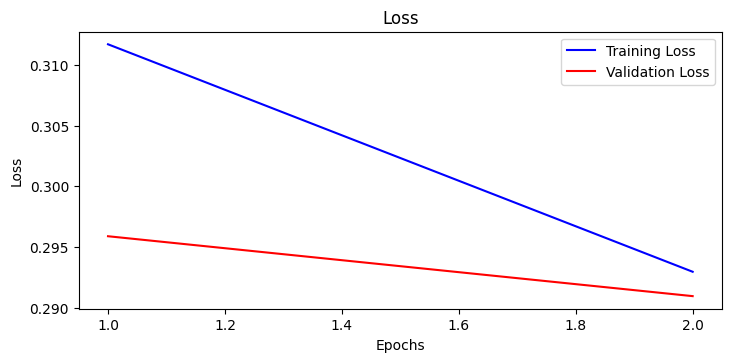

In [ ]:
trainer.plot_metrics()

In [ ]:
detector = trainer.save_model()

# **Predict model**

## **XLM Roberta For Hard-Masked XLM-R sửa từ sai chính tả**

In [ ]:
class HardMasked(nn.Module):
    def __init__(self, detector, MaskedLM, detector_tokenizer, maskedlm_tokenizer, device):
        super(HardMasked, self).__init__()
        self.detector = detector.to(device)
        self.MaskedLM = MaskedLM.to(device)
        self.detector_tokenizer = detector_tokenizer
        self.maskedlm_tokenizer = maskedlm_tokenizer
        self.use_device = device

    def forward(self, s):
        maskedlm_features = self.prepare_input(s)
        outputs = self.MaskedLM(
            input_ids=torch.tensor([maskedlm_features['input_ids']], dtype=torch.long, device=self.use_device),
            attention_mask=torch.tensor([maskedlm_features['attention_mask']], dtype=torch.long, device=self.use_device)
        )
        logits = outputs.logits[0]
        # Lấy chỉ số của các giá trị lớn nhất trên mỗi hàng (từ vựng dự đoán)
        output_ids = torch.argmax(logits, dim=-1)
        print(output_ids)
        # Giải mã từ các chỉ số thành câu văn cuối cùng
        final_output = self.maskedlm_tokenizer.decode(output_ids)
        return final_output


    def prepare_input(self, s):
        # Mã hóa câu đầu vào thành các id token cho mô hình detector
        detector_input_ids = self.detector_tokenizer.encode(s, out_type=int)
        # print(detector_input_ids)
        # Chạy mô hình detector để lấy đầu ra (xác suất các token cần được mask)
        detector_input_pieces = self.detector_tokenizer.id_to_piece(detector_input_ids)
        # print(detector_input_pieces)
        detector_outputs = (self.detector(torch.tensor([detector_input_ids], dtype=torch.long, device=self.use_device))[0].reshape(1,-1) > 0.5).int()[0]

        # print(detector_outputs)

        # Thay thế các token cần mask bằng token [MASK] của mô hình MaskedLM
        for i in range(1, len(detector_input_pieces)):
            if detector_outputs[i] == 1:
                detector_input_pieces[i] = '[MASK]'

        maskedlm_input_pieces = detector_input_pieces
        maskedlm_input_ids = self.maskedlm_tokenizer.convert_tokens_to_ids(maskedlm_input_pieces) # k cần tokenizer lại
        # print("---", maskedlm_input_ids)
        maskedlm_attention_mask = [1] * len(maskedlm_input_ids)
        # print(maskedlm_input_ids)
        # print(maskedlm_attention_mask)

        return {'input_ids': maskedlm_input_ids, 'attention_mask': maskedlm_attention_mask}


In [ ]:
detector_path = f'{LINK_DRIVE}/Dataset/Detector.pkl'

MaskedLM = XLMRobertaForMaskedLM.from_pretrained('xlm-roberta-base')
maskedlm_tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

detector_tokenizer = spm.SentencePieceProcessor(model_file)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Hiển thị cấu trúc của mô hình
print("Cấu trúc của mô hình:")
# print(MaskedLM)

# Hiển thị thông tin về bộ tokenizer
print("\nThông tin về bộ tokenizer:")
print("Vocabulary size:", maskedlm_tokenizer.vocab_size)
print("Các token đặc biệt:", maskedlm_tokenizer.special_tokens_map)

print("Mã hóa mẫu văn bản:")
sample_text = "Hello, how are you?"
# Mã hóa văn bản với các token đặc biệt
encoded_text = maskedlm_tokenizer.encode(sample_text, add_special_tokens=True)
# Giải mã lại để xem các token đặc biệt
decoded_text = maskedlm_tokenizer.decode(encoded_text)
print("Văn bản gốc:", sample_text)
print("Văn bản đã mã hóa:", encoded_text)
print("Văn bản giải mã lại:", decoded_text)

Cấu trúc của mô hình:

Thông tin về bộ tokenizer:
Vocabulary size: 250002
Các token đặc biệt: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}
Mã hóa mẫu văn bản:
Văn bản gốc: Hello, how are you?
Văn bản đã mã hóa: [0, 35378, 4, 3642, 621, 398, 32, 2]
Văn bản giải mã lại: <s> Hello, how are you?</s>


In [ ]:
# Hiển thị thông tin về bộ tokenizer
print("\nThông tin về bộ tokenizer:")
print("Vocabulary size:", detector_tokenizer.vocab_size())

# Văn bản mẫu
# sample_text = "Hello, how are you?"
sample_text = "tại sao a anh?"
print("Văn bản gốc:", sample_text)

# Mã hóa văn bản
encoded_text = detector_tokenizer.encode(sample_text, out_type=int)
print("Văn bản đã mã hóa:", encoded_text)

# Giải mã lại văn bản
decoded_text = detector_tokenizer.decode(encoded_text)
print("Văn bản giải mã lại:", decoded_text)


Thông tin về bộ tokenizer:
Vocabulary size: 23045
Văn bản gốc: tại sao a anh?
Văn bản đã mã hóa: [38, 617, 7, 331, 243, 510]
['▁tại', '▁sao', '▁', 'a', '▁anh', '?']
Văn bản giải mã lại: tại sao a anh?


In [ ]:
predict = HardMasked(detector, MaskedLM, detector_tokenizer, maskedlm_tokenizer, 'cpu')

## **Predict**

In [ ]:
s = 'một ngn ngữ tự nhiên là bất kì ngon ngữ nào phát sinh, không suy nghix trước trong não bộ của con người'
predict(s)

<s> một ngôn ngữ tự nhiên là bất kì ngôn ngữ nào phát sinh, không suy <unk>trước trong não bộ của con người</s>


In [ ]:
s = 'Đi theo anh đến mọi chân trời'
predict(s)

<s> Đi theo anh đến tận chân trời</s>


In [ ]:
s = 'đây là taajp dữ liệu kiểm tra để dự lê'
predict(s)

<s> là <unk>dữ liệu kiểm tra để <unk>lê</s>


## **Evaluate**

In [ ]:
class Evaluate(object):
    def __init__(self, args, model, test_dataloader):
        self.args = args
        self.model = model.to(self.args.device)
        self.test_dataloader = test_dataloader
        self.detector_loss = nn.BCELoss()

    def evaluate(self):
        self.model.eval()
        total_loss = 0
        detector_labels = []
        detector_preds = []
        losses = []
        accuracies = []
        precisions = []
        recalls = []
        f1_scores = []

        with torch.no_grad():
            for batch in tqdm(self.test_dataloader, desc='Evaluating'):
                batch = tuple(t.to(self.args.device) for t in batch)
                input_ids, onehot_labels, output_ids = batch

                detector_prob = self.model(input_ids)
                loss = self.detector_loss(detector_prob.squeeze(dim=-1), onehot_labels.float())
                total_loss += loss.item()
                losses.append(loss.item())

                detector_pred = (detector_prob > 0.5).detach().cpu().numpy().astype(int).squeeze(-1)
                detector_preds.extend(detector_pred)
                detector_labels.extend(onehot_labels.detach().cpu().numpy())

                if len(detector_preds) > 0 and len(detector_labels) > 0:
                    accuracy = accuracy_score(detector_labels, detector_preds)
                    precision = precision_score(detector_labels, detector_preds, average='micro')
                    recall = recall_score(detector_labels, detector_preds, average='micro')
                    f1 = f1_score(detector_labels, detector_preds, average='micro')

                    accuracies.append(accuracy)
                    precisions.append(precision)
                    recalls.append(recall)
                    f1_scores.append(f1)

        avg_loss = total_loss / len(self.test_dataloader)
        return losses, accuracies, precisions, recalls, f1_scores

    def plot_metrics(self, losses, accuracies, precisions, recalls, f1_scores):
        epochs = range(1, len(losses) + 1)

        plt.figure(figsize=(12, 4))

        # Loss plot
        plt.subplot(1, 3, 1)
        plt.plot(epochs, losses, 'b', label='Loss')
        plt.title('Loss over Evaluation Steps')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()

        # F1 Score plot
        plt.subplot(1, 3, 3)
        plt.plot(epochs, f1_scores, 'r', label='F1 Score')
        plt.title('F1 Score over Evaluation Steps')
        plt.xlabel('Steps')
        plt.ylabel('F1 Score')
        plt.legend()

        plt.tight_layout()
        plt.show()

Evaluating:   0%|          | 0/124 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

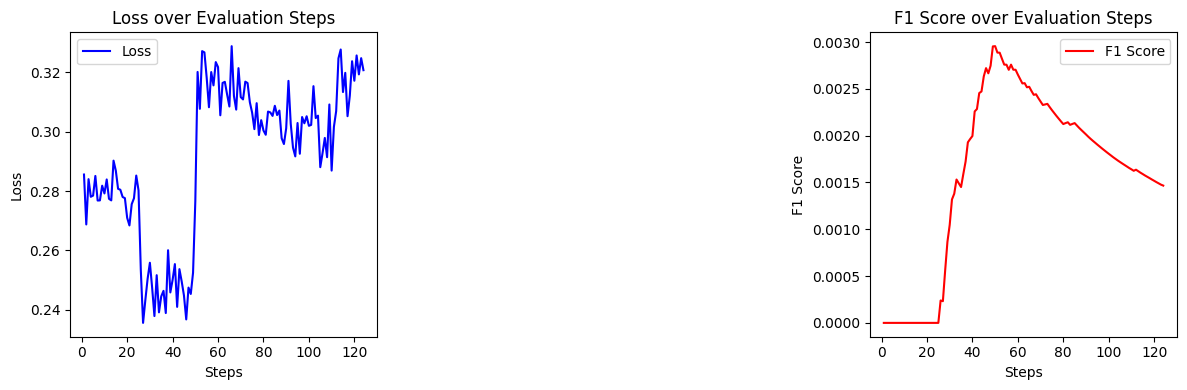

In [ ]:
# Tạo instance của lớp Eval và thực hiện đánh giá
evaluator = Evaluate(args=training_args, model=detector, test_dataloader=test_dataloader)
losses, accuracies, precisions, recalls, f1_scores = evaluator.evaluate()
evaluator.plot_metrics(losses, accuracies, precisions, recalls, f1_scores)